# Deep Neural networks/Multi-layer perceptrons for Sedimentation rate[cm/yr] predictions 

## Train Neural Network

The jupyter notebook shows predictions from a neural network(tensorflow) and a linear regression model(sci-kit). 

Note: the jupyter notebook is not runnable from here. Requires the data. Here is just an example of a run of the code. 

### Multi-layer Perceptron

In [1]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from os import path, makedirs
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

#tf.config.experimental.set_memory_growth(physical_devices[0], True) # solves some GPU memory issues 
np.random.seed(42)
tf.random.set_seed(42)

#print(physical_devices)

2022-10-19 15:49:03.040937: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


**Load data** and pre-processing.

THe feature data has been interpolated using nearest neighbour algorithm to interpolate nan values. In total, we have around 1850 features. 

### **To note: Some features are also averaged over r1000km, r500km, r250km, r100km and r50km. If these are excluded, then the number of features drop down to less than 200.**

But here we also take the averaged feature, since it helps acquiring the neighbourhood data, which the predictions or the sedimentation rates might depend on. 

Since the **dimensions are too high**, and probably the neural network might find it difficult to learn, we try to use some **dimensionality reduction methods, such as PCA, and using a auto encoder**. 

The code for **auto encoder** is at the end of the jupyter notebook

In [2]:
feature_path = Path(Path() / "SedFeaturesnoNAN_nolimit")
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labebels.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)
#lat_labels = np.load(Path(feature_path / "numpy_latitudes_labels.npy")).astype(np.float)
#lon_labels = np.load(Path(feature_path / "numpy_longitudes_labels.npy")).astype(np.float)


#Norm Features
features = np.divide((features - X_mean),X_std)

with open(Path(feature_path / "sorted_features.txt"), "rb") as fp:
    feature_names = pickle.load(fp)


prediction_limit = 5000

# features = features[:,selection_filter]
features = features[labels<prediction_limit,:] #take only TOC < 5% 
# lat_labels = lat_labels[labels<prediction_limit]
# lon_labels = lon_labels[labels<prediction_limit]
labels = labels[labels<prediction_limit]
# labels[labels>prediction_limit] = prediction_limit

#Drop features with NaNs
nan_rows = np.isnan(features).any(axis=0)
np.save("FeatureNanRows",nan_rows)
features = features[:,~nan_rows]
print(nan_rows)



# suffle features/labels
shuffle_idx = np.random.mtrand.randint(low = 0, high = len(labels), size = len(labels))
features = features[shuffle_idx,:]
labels = labels[shuffle_idx]

#features = encoded_features.numpy()
print(features.shape)



#taking the log of labels so that the order of maginitude between deep oceans and the coasts is reduced
#loglabels=np.log10(labels)

model = [None]*10
MAE = []
corrcoef = []
kf = KFold(n_splits=10)
mc_samples = 50


[False False False ... False False False]
(2782, 1845)
(2782, 301)


In [ ]:

# #PCA
pca = PCA (0.995) #95% of the variance is retained
pca.fit(features)
features = pca.transform(features)
print(features.shape)

In [3]:
#features = encoded_features.numpy()
#early stopping and LR-scheduling callbacks
#checkpoint_cb = keras.callbacks.ModelCheckpoint('TOC_nn.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "loss", patience = 200, restore_best_weights = True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.8, patience = 40, min_lr = 0.000001)
do_rate = 0.2
num_nodes = 50
    
model_seed = keras.models.Sequential()
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))




model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))





model_seed.add(keras.layers.Dense(1, activation = "relu"))

model_seed.build([None,features.shape[1]])


2022-10-19 15:49:06.345492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 15:49:06.345662: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:

#%%timeit -n 1 -r 1
#fold = 0
#for train, test in kf.split(features, labels): #startification/10fold
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=1)    
#print("computing fold " + str(fold+1))




model = keras.models.clone_model(model_seed)
model.set_weights(model_seed.get_weights())
model.compile(loss = "mean_absolute_error",
             optimizer = keras.optimizers.Nadam(learning_rate = 0.01),
             metrics = [["RootMeanSquaredError"]])
 
#Final run with early stopping callback
print("running main training round")
 
 
history = model.fit(features_train, labels_train,  epochs = 10000, batch_size= 70, 
                      callbacks = [ early_stopping_cb,lr_scheduler],verbose =2,validation_split=0.2)#
 

In [5]:
#MC Dropout
probs_stack = np.stack([model(features_test,training = True) for sample in range(mc_samples)]) 
probs_stack = probs_stack.reshape([probs_stack.shape[0],probs_stack.shape[1]])
np.savetxt("probs_stack_regression.txt", probs_stack.T)
np.savetxt("labels_test_regression.txt", labels_test)
predictions = tf.squeeze(probs_stack.mean(axis = 0))
np.savetxt("predictions_regression.txt", predictions)
corrcoef.append(np.corrcoef(predictions, labels_test)[0,1])
MAE.append(mean_absolute_error(labels_test,predictions))
 
history_df = pd.DataFrame(history.history)#
#print(history_df)
#print("best val accuracy: " + str(np.max(history_df.val_accuracy)))
print("test MAE:" + str(MAE))
print("test correlation coeficient:" + str(corrcoef))
print("     ----     ")
#fold = fold+1

test MAE:[92.40137333960874]
test correlation coeficient:[0.7396501054759339]
     ----     


In [68]:
features.shape

(2782, 75)

Correlation Coefficient: 0.5435806858197414
MAE: 119.61127704994004
0.6203907501130623
(2782,)
(557,)


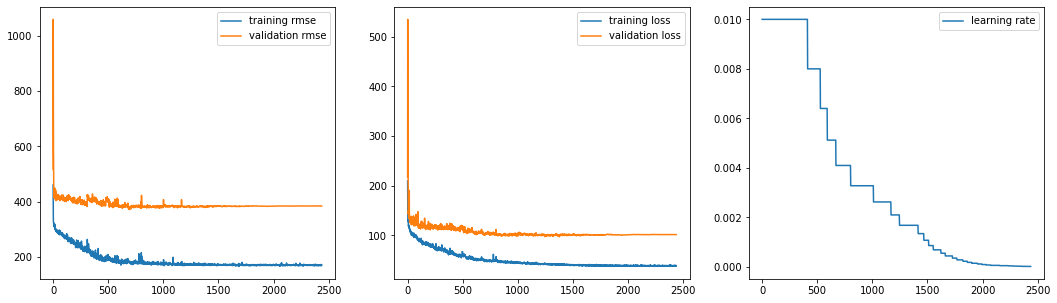

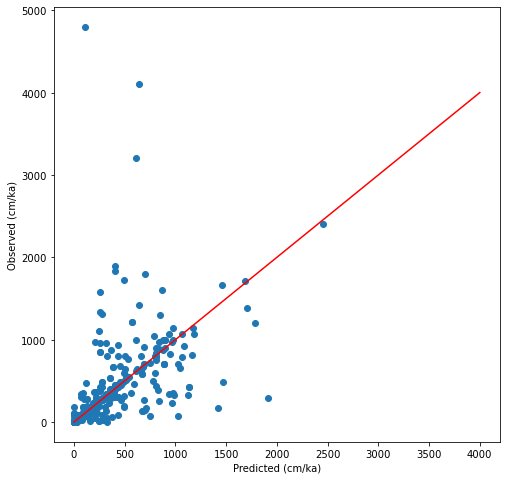

In [69]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(history_df.root_mean_squared_error)
plt.plot(history_df.val_root_mean_squared_error)
plt.legend(["training rmse", "validation rmse"])
#plt.ylim([100,4000])
plt.subplot(132)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(["training loss", "validation loss"])
#plt.ylim([20,400])
plt.subplot(133)
plt.plot(history_df.lr)
plt.legend(["learning rate"])

print("Correlation Coefficient: "+str(np.sum(corrcoef)/len(corrcoef)))
print("MAE: " +str(np.sum(MAE)/len(MAE)))


plt.figure(figsize=[8,8])
#plt.clf()
plt.scatter(predictions,labels_test)
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
plt.xlabel("Predicted (cm/ka)")
plt.ylabel("Observed (cm/ka)")
print(np.corrcoef(predictions,labels_test)[0,1])

dirname = Path("Sed_regresion_083_RestrepoFeats_AllVS0.2_Test")
if not path.isdir(dirname):
    makedirs(dirname)
 
# for idx, model in enumerate(model):
model_name = "Model_nolimitnonan_Test"  + ".h5"
model.save(Path(dirname / model_name))
    
print(labels.shape)
print(labels_test.shape)




## Regression

In [70]:
#%%timeit -n 1 -r 1
#fold = 0
#for train, test in kf.split(features, labels): #startification/10fold
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=1)    
#print("computing fold " + str(fold+1))

In [71]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(features_train, labels_train)
features.shape

(2782, 75)

(557,)
(557, 75)
0.5416621066634344


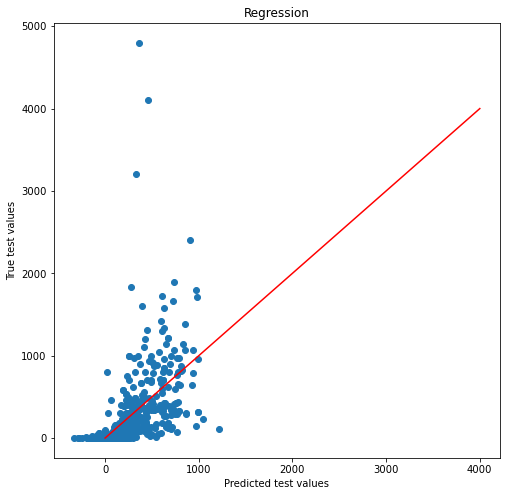

In [72]:
print(reg.predict(features_test).shape)
print(features_test.shape)
plt.figure(figsize=[8,8])
plt.scatter(reg.predict(features_test), labels_test)
plt.title("Regression")
plt.xlabel("Predicted test values")
plt.ylabel("True test values")
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
print(np.corrcoef(reg.predict(features_test), labels_test)[0,1])

## Auto encoder

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

In [7]:
features.shape

(2782, 1845)

In [60]:
# This is the dimension of the original space
input_dim = features.shape[1]

# This is the dimension of the latent space (encoding space)
latent_dim = 75

encoder = Sequential([
    Dense(1000, activation='relu', input_shape=(input_dim,)),
    Dense(500, activation='relu'),
    Dense(250, activation='relu'),
    Dense(100, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(100, activation='relu', input_shape=(latent_dim,)),
    Dense(250, activation='relu'),
    Dense(500, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(input_dim, activation=None)
])

In [61]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
model_history = autoencoder.fit(features, features, epochs=1000, batch_size=70, callbacks = [ early_stopping_cb,lr_scheduler],verbose =2)

plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

Text(0, 0.5, 'Latent Dimension 2')

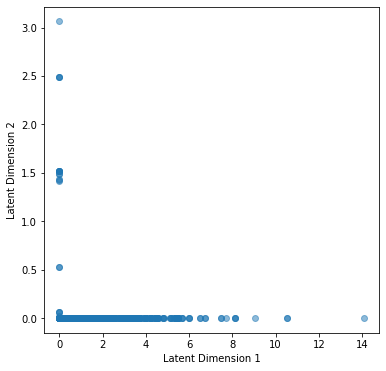

In [64]:
encoded_features = encoder(features)
plt.figure(figsize=(6,6))
plt.scatter(encoded_features[:, 44], encoded_features[:, 9], alpha=.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

In [23]:
np.linalg.norm(features - autoencoder(features).numpy())

66.98173444749557